In [7]:
import os
import sys
import torch
import numpy as np
import json
import pytorch3d

In [8]:
import matplotlib.pyplot as plt
from skimage.io import imread
from utils import *

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    PerspectiveCameras,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    HardPhongShader,
    TexturesAtlas,
)

In [9]:
# Set our device:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [10]:
params = Params("params_demo.json")
obj_filename = params.obj_filename

In [11]:
# Get vertices, faces, and auxiliary information:
verts, faces, aux = load_obj(
    "data/cow_mesh/cow.obj",
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat"
     )

# Create a textures object
atlas = aux.texture_atlas

# Initialize the mesh with vertices, faces, and textures.
# Created Meshes object
capsule_mesh = Meshes(
    verts=[verts],
    faces=[faces.verts_idx],
    textures=TexturesAtlas(atlas=[atlas]),)

/home/yx0203/SDKs/Python/Anaconda/envs/p3d/lib/python3.9/site-packages/pytorch3d/io/mtl_io.py:102: UserWarning: Texture UV coordinates outside the range [0, 1].                 The integer part will be ignored to form a repeating pattern.
  warnings.warn(msg)


In [12]:
from iopath.common.file_io import PathManager
from pytorch3d.io import IO, ply_io

ply_mesh = ply_io.MeshPlyFormat()
capsule_mesh = ply_mesh.read(
    "data/lm_models/obj_000001.ply",
    True,
    device,
    PathManager())

torch.Size([1, 3, 3]) torch.Size([1, 3])


(-0.5, 639.5, 479.5, -0.5)

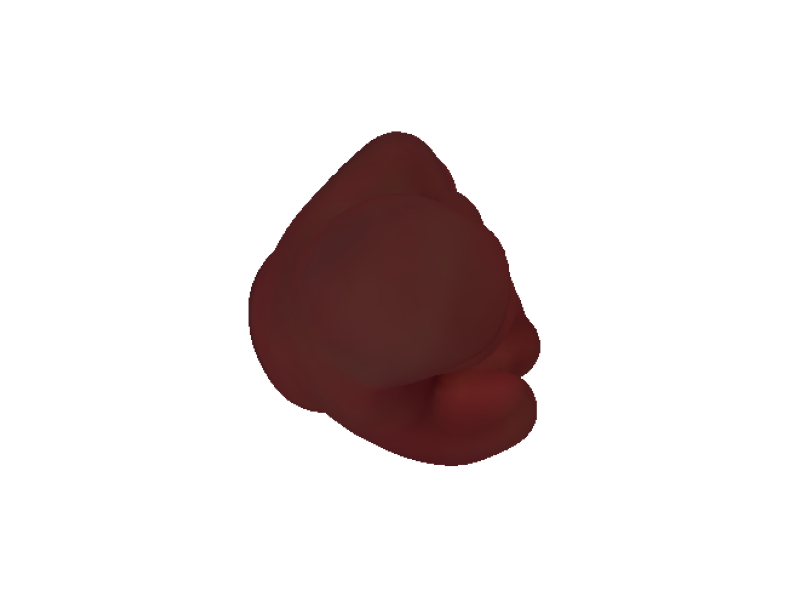

In [27]:
# Initialize the camera with camera distance, elevation, and azimuth angle
R, T = look_at_view_transform(dist = params.camera_dist, elev = 
                              params.elevation, azim = params.azim_angle) 
print(R.shape, T.shape)

fx, fy, px, py = 572.4114, 573.57043, 325.2611, 242.04899
h, w = 480, 640

f = torch.tensor((fx, fy), dtype=torch.float32).unsqueeze(0)
p = torch.tensor((px, py), dtype=torch.float32).unsqueeze(0)
# image_size_wh = image_size.to(R).flip(dims=(1,))
# principal_point = principal_point.flip(dims=(1,))
img_size= torch.tensor((h, w), dtype=torch.float32).unsqueeze(0)
    
cameras = PerspectiveCameras(
    R=R, T=T,
    focal_length=f,
    principal_point=p,
        image_size=((h, w),),
        device=device,
        in_ndc=False)

# Here we set the output image to be of size 256 x 256 based on config.json 
raster_settings = RasterizationSettings(
    image_size = (h, w), 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )



torch.Size([1, 3, 3]) torch.Size([1, 3])


(-0.5, 639.5, 479.5, -0.5)

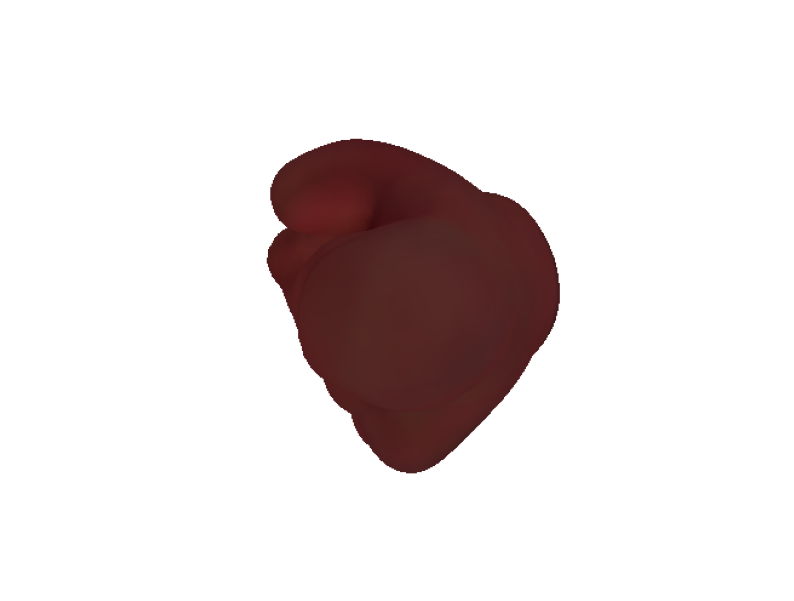

In [26]:
from pytorch3d.utils import cameras_from_opencv_projection
R, T = look_at_view_transform(dist = params.camera_dist, elev = 
                              params.elevation, azim = params.azim_angle) 
print(R.shape, T.shape)

fx, fy, px, py = 572.4114, 573.57043, 325.2611, 242.04899
h, w = 480, 640

K = np.array([[572.4114, 0.,         325.2611],
              [0.,        573.57043,  242.04899],
              [0.,        0.,         1.]])

f = torch.tensor((fx, fy), dtype=torch.float32).unsqueeze(0)
p = torch.tensor((px, py), dtype=torch.float32).unsqueeze(0)
img_size= torch.tensor((h, w), dtype=torch.float32).unsqueeze(0)
    
camera_matrix = torch.tensor(K, dtype=torch.float32).unsqueeze(0)
image_size= torch.tensor((h, w), dtype=torch.float32).unsqueeze(0)

cameras = cameras_from_opencv_projection(
    R=R, tvec=T,
    camera_matrix= camera_matrix,
    image_size= image_size
).to(device)

# Here we set the output image to be of size 256 x 256 based on config.json 
raster_settings = RasterizationSettings(
    image_size = (h, w), 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )

(-0.5, 639.5, 479.5, -0.5)

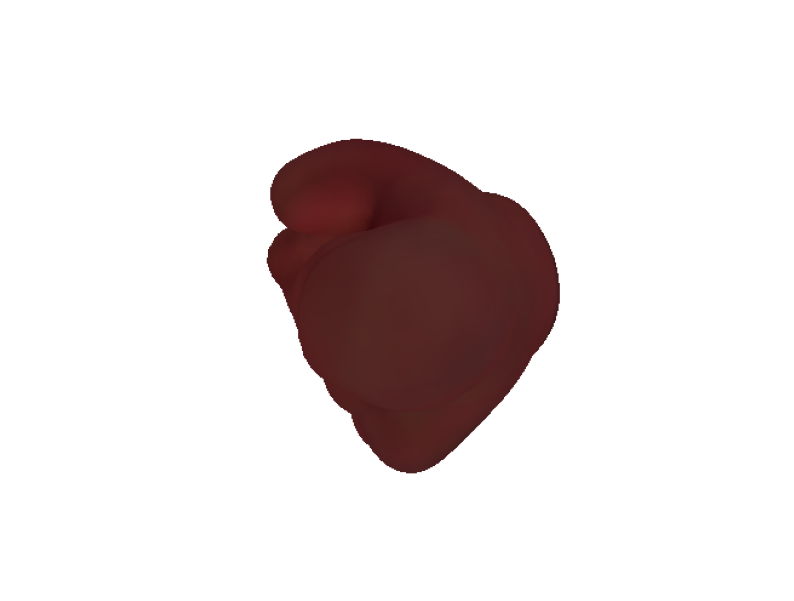

In [22]:
# The textured phong shader interpolates the texture uv coordinates for 
# each vertex, and samples from a texture image.
shader = HardPhongShader(device = device, cameras = cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)
# Render Meshes object
image = renderer(capsule_mesh)
# Plot rendered image
plt.figure(figsize=(10, 10))
plt.imshow(image[0, ..., :3].cpu().numpy())
plt.grid("off")
plt.axis("off")

RasterObjectModel3D::createShader() - Shader_version: 4.60 NVIDIA


(-0.5, 639.5, 479.5, -0.5)

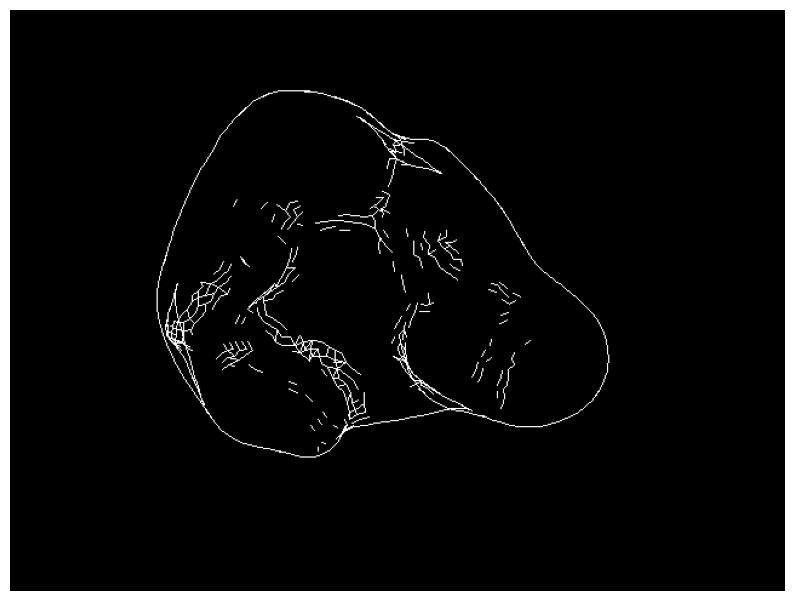

In [28]:
from RasterModel.rastermodel import RaseterObjectModel, UoM

K = np.array([[572.4114, 0.,         325.2611],
              [0.,        573.57043,  242.04899],
              [0.,        0.,         1.]])

rasterModel = RaseterObjectModel("data/lm_models/obj_000001.ply",uom=UoM.MILLIMETER)
rasterModel.setCamParams(K, w, h)

edge_map = np.zeros((480, 640, 3), np.uint8)

r, t = R[0].cpu().numpy(), T[0].cpu().numpy().reshape(3,-1)/1000
pose = np.concatenate([r, t], axis=1)
rasterModel.setModelView(pose)
edge = rasterModel.getEdgeMapBySegments(edge_map.copy(), (255, 255, 255))
plt.figure(figsize=(10, 10))
plt.imshow(edge)
plt.grid("off")
plt.axis("off")

In [16]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 36

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(0, 360, batch_size)
azim = torch.linspace(-180, 180, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = params.camera_dist, elev = elev, azim = params.azim_angle)
print(R.shape, T.shape)

# cameras = FoVPerspectiveCameras(device=device, R=R, T=T)
# cameras = PerspectiveCameras(
#     R=R, T=T,
#     focal_length=f,
#     principal_point=p,
#         image_size=((h, w),),
#         device=device,
#         in_ndc=False)

K = np.array([[572.4114, 0.,         325.2611],
              [0.,        573.57043,  242.04899],
              [0.,        0.,         1.]])

camera_matrix = torch.tensor(K, dtype=torch.float32).unsqueeze(0).repeat(batch_size,1,1)
image_size= torch.tensor((h, w), dtype=torch.float32).unsqueeze(0).repeat(batch_size,1)

from pytorch3d.utils import cameras_from_opencv_projection
cameras = cameras_from_opencv_projection(
    R=R, tvec=T,
    camera_matrix= camera_matrix,
    image_size= image_size
).to(device)

torch.Size([36, 3, 3]) torch.Size([36, 3])


In [17]:
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)
print(images.shape)

torch.Size([36, 480, 640, 4])


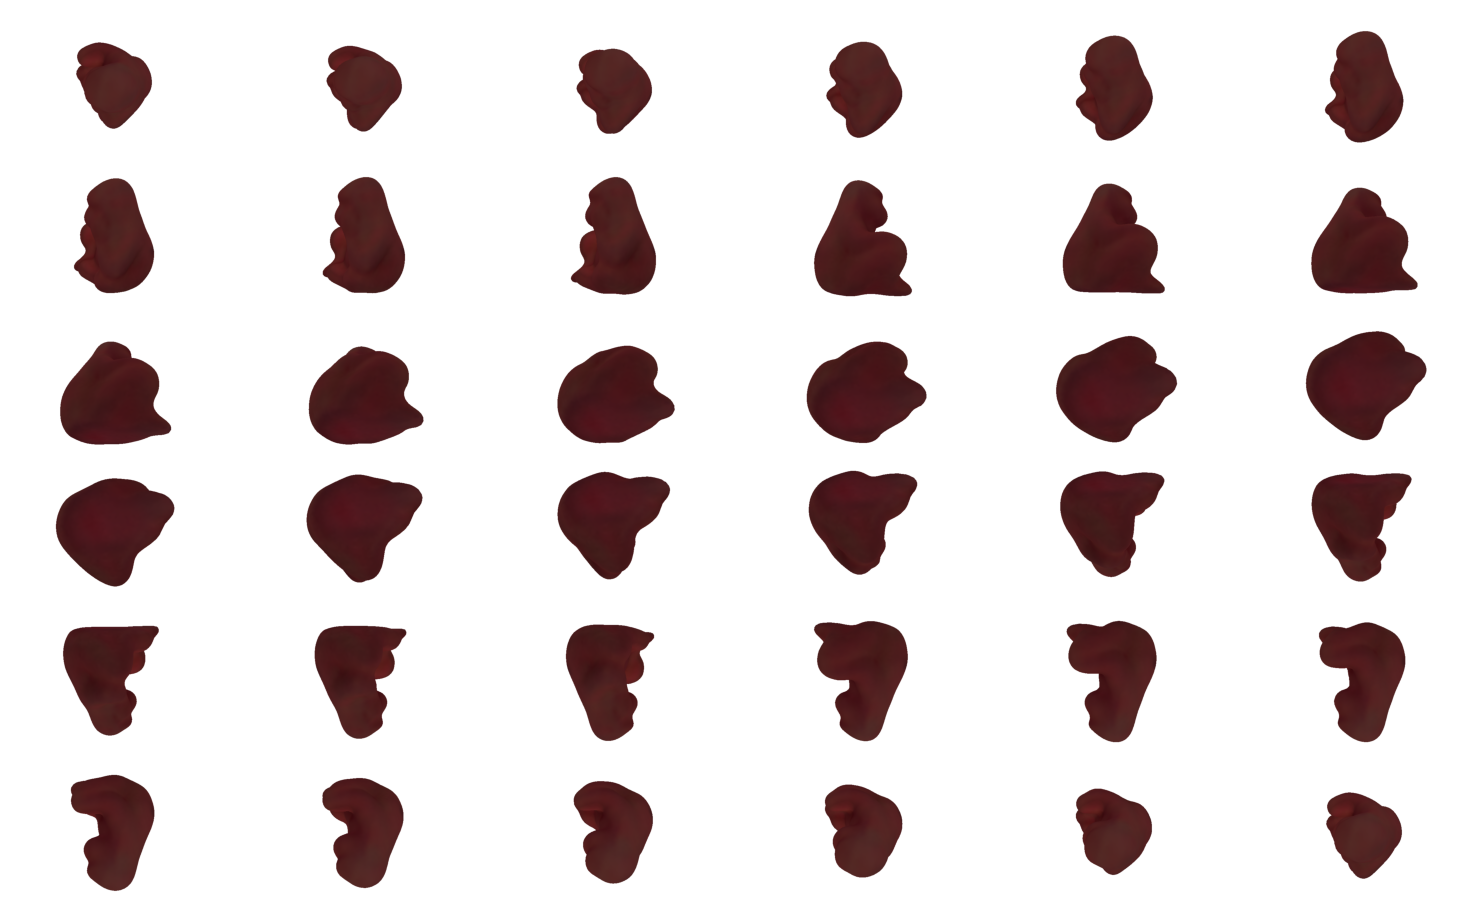

In [18]:
# Plot the rendered images
image_grid(images.cpu().numpy(), rows=int(np.sqrt(batch_size)), cols=int(np.sqrt(batch_size)), rgb=True)

In [19]:
elev

tensor([  0.0000,  10.2857,  20.5714,  30.8571,  41.1429,  51.4286,  61.7143,
         72.0000,  82.2857,  92.5714, 102.8571, 113.1429, 123.4286, 133.7143,
        144.0000, 154.2857, 164.5714, 174.8571, 185.1429, 195.4286, 205.7143,
        216.0000, 226.2857, 236.5714, 246.8571, 257.1429, 267.4286, 277.7143,
        288.0000, 298.2857, 308.5714, 318.8571, 329.1429, 339.4286, 349.7143,
        360.0000])

In [20]:
azim

tensor([-180.0000, -169.7143, -159.4286, -149.1429, -138.8571, -128.5714,
        -118.2857, -108.0000,  -97.7143,  -87.4286,  -77.1429,  -66.8571,
         -56.5714,  -46.2857,  -36.0000,  -25.7143,  -15.4286,   -5.1429,
           5.1429,   15.4286,   25.7143,   36.0000,   46.2857,   56.5714,
          66.8571,   77.1429,   87.4286,   97.7143,  108.0000,  118.2857,
         128.5714,  138.8571,  149.1429,  159.4286,  169.7143,  180.0000])

RasterObjectModel3D::createShader() - Shader_version: 4.60 NVIDIA


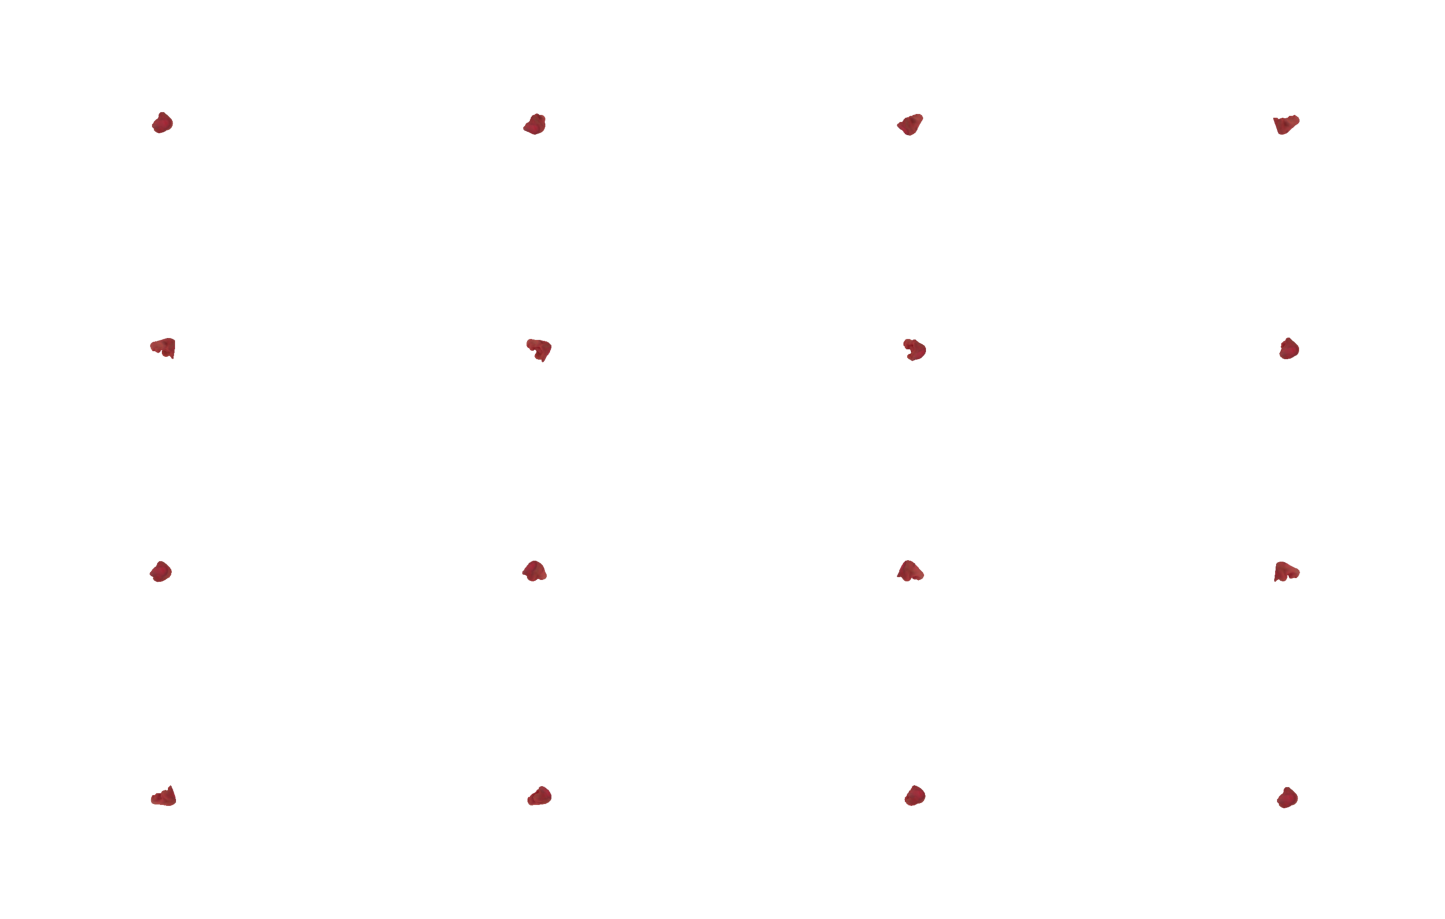